# Astronomical Images Classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Chapter 0: Data Preparation

In this chapter, we retrieve astronomical images and metadata from the Sloan Digital Sky Survey (SDSS) using its SkyServer API. We join the `PhotoObj` and `Field` tables to obtain not only object photometric quantities (u, g, r, i, z magnitudes) but also the PSF full-width at half-maximum in the r-band (`psf_fwhm_r`), which we will later use to inform our edge-detection parameters (see PID §3.0.1). Finally, we save the images and metadata locally and create a ZIP archive for easy sharing.

In [46]:
# 1 · Imports and Path Setup
import os
import random
import zipfile
import urllib.request
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

DATASET_PATH     = "dataset"
SDSS_API_URL     = "http://skyserver.sdss.org/dr18/SkyServerWS/SearchTools/SqlSearch"
ZIP_OUT          = f"{DATASET_PATH}/sdss_dataset.zip"
os.makedirs(DATASET_PATH, exist_ok=True)


## SQL Query Template

We construct a parameterized SQL query to fetch up to 5 000 objects of a given type (`STAR` or `GALAXY`, SDSS type IDs 6 and 3 respectively).  
We select:
- **objID, ra, dec**: unique identifier and sky coordinates  
- **u, g, r, i, z**: SDSS magnitudes used later for color indices (§2.2 of PID)  
- **psfWidth_r** as `psf_fwhm_r`: median seeing estimate in the r-band  
- **img_url**: a prebuilt URL to download a 128×128 pixel JPEG cutout at 0.2″/pixel  


In [ ]:
QUERY = """
SELECT TOP 2000
  p.objID, p.ra, p.dec, p.u, p.g, p.r, p.i, p.z, p.type,
  f.psfWidth_r AS psf_fwhm_r,
  'http://skyserver.sdss.org/dr18/SkyServerWS/ImgCutout/getjpeg?ra='
    + CONVERT(nvarchar, p.ra) + '&dec=' + CONVERT(nvarchar, p.dec)
    + '&scale=0.2&width=128&height=128' AS img_url
FROM PhotoObj AS p
JOIN Field AS f ON p.fieldID = f.fieldID
WHERE p.type = {class_id}
"""
CLASSES = {"STAR": 6, "GALAXY": 3}


## Fetch & Download Functions

- **`fetch_sdss`** runs the SQL query and returns the JSON rows.  
- **`download`** saves each image into a class-named folder and collects metadata into a list for CSV output.


In [ ]:
def fetch_sdss(class_name, class_id):
    sql = QUERY.format(class_id=class_id)
    resp = requests.get(SDSS_API_URL, params={"cmd": sql, "format": "json"})
    try:
        return resp.json()[0]["Rows"]
    except Exception:
        return []

def download(class_name, rows, collector):
    out_dir = os.path.join(DATASET_PATH, class_name)
    os.makedirs(out_dir, exist_ok=True)
    for row in tqdm(rows, desc=f"Downloading {class_name}"):
        fname = f"{row['objID']}.jpg"
        path  = os.path.join(out_dir, fname)
        urllib.request.urlretrieve(row["img_url"], path)
        collector.append([
            fname, class_name,
            row["ra"], row["dec"],
            row["u"], row["g"], row["r"], row["i"], row["z"],
            row.get("psf_fwhm_r")
        ])


## Download Loop

We iterate over `STAR` and `GALAXY`, fetching metadata then saving images.  
Afterwards, we assemble a pandas DataFrame and write `metadata.csv` under `DATASET_PATH`.


In [ ]:
metadata = []
for cls, cid in CLASSES.items():
    rows = fetch_sdss(cls, cid)
    if rows:
        download(cls, rows, metadata)

cols = ["filename","class","ra","dec","u","g","r","i","z","psf_fwhm_r"]
pd.DataFrame(metadata, columns=cols).to_csv(f"{DATASET_PATH}/metadata.csv", index=False)


## Create ZIP Archive

We package the entire dataset (images + metadata) into a ZIP file for easy transfer or backup.


In [ ]:
with zipfile.ZipFile(ZIP_OUT, "w", zipfile.ZIP_DEFLATED) as zf:
    for root, _, files in os.walk(DATASET_PATH):
        for fname in files:
            full = os.path.join(root, fname)
            rel  = os.path.relpath(full, DATASET_PATH)
            zf.write(full, rel)
print("Zipped dataset:", ZIP_OUT)


## Quick Data Inspection

Load and plot class distribution, then display random samples from each class.


In [ ]:
# Load metadata
meta = pd.read_csv(f"{DATASET_PATH}/metadata.csv")

# Class distribution bar plot
meta["class"].value_counts().plot(kind="bar")
plt.title("Object Class Distribution")
plt.xlabel("Class"); plt.ylabel("Count")
plt.show()

# Function to display samples
def show_samples(n=10):
    for cls in meta["class"].unique():
        subset = meta[meta["class"]==cls]["filename"].sample(n).tolist()
        fig, axs = plt.subplots(1, n, figsize=(n*1.3, 3))
        for ax, fname in zip(axs, subset):
            img = mpimg.imread(os.path.join(DATASET_PATH, cls, fname))
            ax.imshow(img); ax.axis("off")
        plt.suptitle(cls); plt.show()

show_samples(5)


# Chapter 1: Data Loading and Noise Reduction

In this section, we prepare the workspace for the pipeline.  
We mount Google Drive, define data paths, and ensure that necessary directories are created.  
This prepares the environment for subsequent image processing stages.

In [48]:
import os
import zipfile
import random
import glob
import cv2
import numpy as np
import pandas as pd
from numba import jit
from scipy import fftpack
from scipy.fftpack import fftshift
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

WORK_DIR = "astro_processing"

RAW_DATA_DIR = DATASET_PATH
DENOISED_DATA_DIR = os.path.join(WORK_DIR, "denoised_dataset")
FEATURES_DIR = os.path.join(WORK_DIR, "features")
METADATA_CSV_PATH = os.path.join(DATASET_PATH, "metadata.csv")
FEATURES_STEP1_CSV_PATH = os.path.join(FEATURES_DIR, "features_step1.csv")

os.makedirs(WORK_DIR, exist_ok=True)
os.makedirs(RAW_DATA_DIR, exist_ok=True)
os.makedirs(DENOISED_DATA_DIR, exist_ok=True)
os.makedirs(FEATURES_DIR, exist_ok=True)
os.makedirs(os.path.join(DENOISED_DATA_DIR, "STAR"), exist_ok=True)
os.makedirs(os.path.join(DENOISED_DATA_DIR, "GALAXY"), exist_ok=True)


## 1.1 Load Metadata

Load the metadata file, which contains the photometric attributes (`u`, `g`, `r`, `i`, `z` bands)  
and basic information such as class labels (`STAR`, `GALAXY`).

This information will be later combined with morphological features for classification.

In [49]:
try:
    metadata_df = pd.read_csv(METADATA_CSV_PATH)
    print(f"Loaded metadata: {len(metadata_df)} entries")
except Exception as e:
    print(f"Error loading metadata CSV: {e}")
    raise SystemExit("Could not load metadata.")


Loaded metadata: 3999 entries


## 1.2 Denoising with Non-Local Means


Astronomical images from SDSS may include background noise due to sensor limitations or atmospheric conditions.  
To enhance feature extraction, we apply a Non-Local Means (NLM) denoising filter, which preserves structural details while reducing noise.

The algorithm compares each pixel's neighborhood with others across the image and performs a weighted average, based on similarity.  
This method is especially effective in preserving faint astronomical structures such as edges, gradients, and filaments.

In [81]:
from numba import jit
import numpy as np
import cv2

@jit(nopython=True, cache=True)
def findAllNeighbors(padImg, small_window, big_window, h, w):
    smallWidth = small_window // 2
    bigWidth = big_window // 2
    neighbors = np.zeros((padImg.shape[0], padImg.shape[1], small_window, small_window), dtype=np.float64)
    for i in range(bigWidth, bigWidth + h):
        for j in range(bigWidth, bigWidth + w):
            neighbors[i, j] = padImg[(i - smallWidth):(i + smallWidth + 1), (j - smallWidth):(j + smallWidth + 1)]
    return neighbors

@jit(nopython=True, cache=True)
def evaluateNorm(pixelWindow, neighborWindow, Nw):
    Ip_Numerator, Z = 0.0, 0.0
    neighbor_rows, neighbor_cols, _, _ = neighborWindow.shape
    for i in range(neighbor_rows):
        for j in range(neighbor_cols):
            q_window = neighborWindow[i, j]
            q_x, q_y = q_window.shape[0] // 2, q_window.shape[1] // 2
            Iq = q_window[q_x, q_y]
            diff_sq = np.sum((pixelWindow.astype(np.float64) - q_window) ** 2)
            w = np.exp(-diff_sq / Nw)
            Ip_Numerator += w * Iq
            Z += w
    if Z == 0:
        return 0.0
    return Ip_Numerator / Z

class NLMeans:
    def solve(self, img, h=10, small_window=5, big_window=21):
        img_float = img.astype(np.float64)
        padImg = np.pad(img_float, big_window // 2, mode='reflect')
        denoised_float = self.NLM(padImg, img_float, float(h), small_window, big_window)
        denoised_uint8 = np.clip(denoised_float, 0, 255).astype(np.uint8)
        return denoised_uint8

    @staticmethod
    @jit(nopython=True, cache=True)
    def NLM(padImg, img, h, small_window, big_window):
        Nw = float((h ** 2) * (small_window ** 2))
        if Nw == 0:
            Nw = 1e-9
        h_img, w_img = img.shape
        result = np.zeros(img.shape, dtype=np.float64)
        bigWidth = big_window // 2
        neighbors = findAllNeighbors(padImg, small_window, big_window, h_img, w_img)
        for i in range(bigWidth, bigWidth + h_img):
            for j in range(bigWidth, bigWidth + w_img):
                pixelWindow = neighbors[i, j]
                neighborWindow = neighbors[(i - bigWidth):(i + bigWidth + 1), (j - bigWidth):(j + bigWidth + 1)]
                Ip = evaluateNorm(pixelWindow, neighborWindow, Nw)
                result[i - bigWidth, j - bigWidth] = Ip
        return result


## 1.3 Image Processing: Loading, Denoising, and Saving


For each object in the metadata, we:

1. Load the grayscale image from disk.
2. Apply the NLM filter to denoise it.
3. Save the result in a dedicated output directory.

This denoised version is used in subsequent feature extraction stages such as PSA and edge analysis.
All filenames and class labels are preserved to ensure traceability.

In [82]:
import os
import pandas as pd
import cv2
from tqdm import tqdm

os.makedirs(DENOISED_DATA_DIR, exist_ok=True)
os.makedirs(os.path.join(DENOISED_DATA_DIR, "STAR"), exist_ok=True)
os.makedirs(os.path.join(DENOISED_DATA_DIR, "GALAXY"), exist_ok=True)

metadata_df = pd.read_csv(METADATA_CSV_PATH)

nlm_denoiser = NLMeans()

for _, row in tqdm(metadata_df.iterrows(), total=len(metadata_df), desc="Denoising Images"):
    filename = row['filename']
    obj_class = row['class']
    raw_img_path = os.path.join(RAW_DATA_DIR, obj_class, filename)
    denoised_img_path = os.path.join(DENOISED_DATA_DIR, obj_class, filename)

    img_gray = cv2.imread(raw_img_path, cv2.IMREAD_GRAYSCALE)
    if img_gray is None:
        continue

    denoised_img = nlm_denoiser.solve(img_gray, h=10, small_window=5, big_window=21)
    cv2.imwrite(denoised_img_path, denoised_img)


Denoising Images: 100%|██████████| 3999/3999 [00:00<00:00, 4458.92it/s]


## 1.4 Power Spectrum Analysis (PSA) Feature Extraction

To characterize spatial frequency patterns in each image, we apply a 2D Fast Fourier Transform (FFT) to obtain the power spectrum.  
This highlights the distribution of high- and low-frequency content, which is informative for distinguishing object morphology.

From the radial profile of the spectrum, we extract:

- **Mean power**: overall signal strength.
- **Low-to-high frequency ratio**: how much energy is concentrated in smoother regions.
- **Naive class guess**: a heuristic prediction based on frequency dominance (stars tend to concentrate energy near the center).

These features are later integrated into the classification model.

In [136]:
import numpy as np
from scipy.fft import fft2, fftshift

class PSA():
    def fft_image(self, img):
        return fft2(img.astype(np.float64))

    def power_spectrum(self, fft_img):
        return np.abs(fft_img) ** 2

    def radial_profile(self, data):
        h, w = data.shape
        center = (w // 2, h // 2)
        y, x = np.indices((h, w))
        r = np.sqrt((x - center[0])**2 + (y - center[1])**2).astype(np.int32)
        r_flat = r.ravel()
        data_flat = data.ravel()

        tbin = np.bincount(r_flat, weights=data_flat)
        nr = np.bincount(r_flat)

        radialprofile = np.zeros_like(tbin)
        radialprofile[nr > 0] = tbin[nr > 0] / nr[nr > 0]
        return radialprofile

    def extract_psa_features(self, img):
        fft_img = self.fft_image(img)
        fft_img_shifted = fftshift(fft_img)
        power_spec = self.power_spectrum(fft_img_shifted)
        radial_ps = self.radial_profile(power_spec)

        mean_power = np.mean(radial_ps)
        low_freq_sum = np.sum(radial_ps[1:10])
        high_freq_sum = np.sum(radial_ps[10:30])

        if high_freq_sum > 1e-9:
            low_high_ratio = low_freq_sum / high_freq_sum
        else:
            low_high_ratio = 0.0

        return {
            'psa_mean_power': mean_power,
            'psa_low_high_ratio': low_high_ratio
        }


## 1.5 Generate Denoised Images and Extract PSA Features

This step processes the full dataset:

- Denoises each image using Non-Local Means.
- Computes the FFT and PSA features.
- Saves the denoised image to disk.
- Stores the extracted features into a CSV.

The resulting feature table combines metadata (class, magnitudes) and PSA descriptors,
serving as the input for later stages such as edge detection and classification.

In [ ]:
import os
import pandas as pd
import cv2
from tqdm import tqdm

# Paths
RAW_DIR = './dataset'
DENOISED_DIR = './astro_processing/denoised_dataset'
FEATURES_DIR = './astro_processing/features'
os.makedirs(DENOISED_DIR, exist_ok=True)
os.makedirs(FEATURES_DIR, exist_ok=True)

# Load metadata
metadata_df = pd.read_csv('./dataset/metadata.csv')

# Initialize PSA extractor and denoiser
psa_extractor = PSA()
nlmeans = NLMeans()

features_list = []

for idx, row in tqdm(metadata_df.iterrows(), total=len(metadata_df), desc="Processing images"):
    filename = row['filename']
    obj_class = row['class']

    input_path = os.path.join(RAW_DIR, obj_class, filename)
    output_path = os.path.join(DENOISED_DIR, obj_class, filename)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue

    denoised_img = nlmeans.solve(img)
    cv2.imwrite(output_path, denoised_img)
    # Extract PSA features
    features = psa_extractor.extract_psa_features(denoised_img)
    features['filename'] = filename
    features['original_class'] = obj_class
    features_list.append(features)

# Convert list of feature dicts to DataFrame
features_df = pd.DataFrame(features_list)

# Save to CSV
features_path = os.path.join(FEATURES_DIR, "features_step1.csv")
features_df.to_csv(features_path, index=False)




Processing images:   0%|          | 0/3999 [00:00<?, ?it/s]

Processing images:  55%|█████▍    | 2188/3999 [1:07:51<52:32,  1.74s/it]  

# Chapter 2: Edge Feature Extraction

In this chapter, we apply multiple edge detection algorithms to the denoised images,
combine the best-performing methods into a single "super edge map," and extract new features
from these edge representations. These features will be later used to improve classification performance.

We use the following detectors:
- Frangi ridge detection (multi-scale filament emphasis)
- Adaptive wavelet-based detection
- Gradient of Laplacian (LoG gradient)

We no longer use Canny edges, as experiments showed it degraded the model performance.

Finally, features are extracted from the combined edge map, and color-based features are also computed.



## 2.1 Setup and Preprocessing

This section prepares the environment for edge detection and feature extraction.

It includes:
- Installing required libraries.
- Importing necessary modules.
- Creating directories for edge outputs.
- Loading previously saved metadata and features from Chapter 1.

In [ ]:
%pip install scikit-image pywavelets

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [86]:
import os
import cv2
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from skimage.filters import frangi
from scipy.ndimage import gaussian_laplace, gaussian_gradient_magnitude
import pywt
from tqdm.notebook import tqdm


In [ ]:
# Define paths for output
EDGE_MAPS_DIR = os.path.join(WORK_DIR, "edge_maps")
FEATURES_STEP2_CSV_PATH = os.path.join(FEATURES_DIR, "features_step2.csv")

# Create required folders
os.makedirs(EDGE_MAPS_DIR, exist_ok=True)
os.makedirs(os.path.join(EDGE_MAPS_DIR, "STAR"), exist_ok=True)
os.makedirs(os.path.join(EDGE_MAPS_DIR, "GALAXY"), exist_ok=True)


In [ ]:
print(f"Edges Directory: {EDGE_MAPS_DIR}")
print(f"Features Step 2 will be saved at: {FEATURES_STEP2_CSV_PATH}")

Combined Edges Directory: ./astro_processing\combined_edges
Features Step 2 will be saved at: ./astro_processing\features\features_step2.csv


In [ ]:
# Load metadata from Chapter 1
try:
    if 'metadata_df' not in locals():
        if not os.path.exists(METADATA_CSV_PATH):
            alt_metadata_path = os.path.join(WORK_DIR, "metadata.csv")
            if os.path.exists(alt_metadata_path):
                METADATA_CSV_PATH = alt_metadata_path
            else:
                raise FileNotFoundError(f"Metadata CSV not found in {METADATA_CSV_PATH} or {alt_metadata_path}")
        metadata_df = pd.read_csv(METADATA_CSV_PATH)
        print(f"Loaded metadata: {len(metadata_df)} entries.")
    else:
        print("Using metadata_df loaded from previous chapter.")
except Exception as e:
    print(f"Error loading metadata: {e}")
    raise SystemExit()


Using metadata_df loaded from previous chapter.


In [ ]:
# Load Step 1 features
try:
    features_step1_df = pd.read_csv(FEATURES_STEP1_CSV_PATH)
    print(f"Loaded features from Step 1: {len(features_step1_df)} entries.")
except Exception as e:
    print(f"Error loading Step 1 features: {e}")
    raise SystemExit()


Loaded features from Step 1: 1 entries.


## 2.2 Edge Detector Definitions


This section defines the individual edge detection algorithms that are later combined to form a more robust feature set.

We tested multiple detectors and experimentally selected the best three:
- **Frangi Ridge Filter**: Enhances filamentary structures such as spiral arms.
- **Wavelet Thresholding**: Captures multi-scale directional changes in texture.
- **Gradient of Laplacian of Gaussian (GoL)**: Isolates diffuse edges and fine-scale gradients.

Although Canny is included below for completeness and comparison, it is not used in the final edge feature set due to poorer discriminative performance.

Each detector is adapted using metadata (e.g., color indices or magnitudes) for astrophysical context-awareness.

In [56]:
# Canny: basic edge detection, thresholds adapted using z-band magnitude
def astronomical_canny(img, meta):
    if 'z' not in meta or pd.isna(meta['z']):
        return cv2.Canny(img, 50, 150)  # fallback thresholds

    z_mag = meta['z']
    # Thresholds scale inversely with magnitude (brighter → higher thresholds)
    low_thresh = int(np.clip(30 + (22 - z_mag) * 5, 10, 200))
    high_thresh = int(np.clip(80 + (22 - z_mag) * 10, 30, 255))
    if low_thresh >= high_thresh:
        low_thresh = int(high_thresh * 0.4)

    return cv2.Canny(img, low_thresh, high_thresh)

# Frangi Ridge Detector: detects elongated structures (e.g., spiral arms)
def multi_scale_ridge_detection(img, meta):
    if any(m not in meta or pd.isna(meta[m]) for m in ['u', 'z', 'g', 'r']):
        return frangi(img, scale_range=(1, 5, 2), beta=0.5, black_ridges=False)

    color_uv_z = meta['u'] - meta['z']
    color_g_r = meta['g'] - meta['r']

    # Scale range based on UV-to-Z color (bluer → finer scales)
    base_scale = max(1, int(1 + color_uv_z / 2.0))
    scales = (base_scale, base_scale + 1, base_scale + 2)

    # Beta (structure enhancement) adapted from g-r color
    beta = np.clip(0.5 + (color_g_r / 2.0), 0.1, 1.5)

    return frangi(img.astype(float), scale_range=scales, beta=beta, black_ridges=False)

# Wavelet-based edges: decomposes image into multi-resolution components
def adaptive_wavelet_edges(img, meta):
    if 'r' not in meta or pd.isna(meta['r']):
        threshold_factor = 1.5
        med = np.median(np.abs(pywt.wavedec2(img, 'db4', level=1)[-1][0]))
        threshold = threshold_factor * med
    else:
        snr = 10**(0.4 * (25 - meta['r']))  # rough signal-to-noise estimate
        threshold_factor = np.clip(1.0 + 5.0 / (snr + 1.0), 1.0, 4.0)

        coeffs1 = pywt.wavedec2(img, 'db4', level=1)
        details = np.concatenate([coeffs1[-1][i].ravel() for i in range(3)])
        mad = np.median(np.abs(details - np.median(details)))
        sigma = mad / 0.6745
        threshold = threshold_factor * sigma

    coeffs = pywt.wavedec2(img, 'db4', level=3)
    processed = [coeffs[0]] + [tuple(pywt.threshold(d, threshold, mode='soft') for d in c) for c in coeffs[1:]]
    reconstructed = pywt.waverec2(processed, 'db4')

    return reconstructed[:img.shape[0], :img.shape[1]]

# Gradient of Laplacian of Gaussian (GoL): captures fine-scale transitions
def gradient_of_laplacian(img):
    log_img = gaussian_laplace(img.astype(float), sigma=2.0)
    return gaussian_gradient_magnitude(log_img, sigma=1.5)


In [88]:
def calculate_entropy(edges_norm):
    """ Calculates Shannon entropy for a normalized edge map """
    # Ensure input is normalized [0, 1]
    edges_norm = np.clip(edges_norm, 0, 1)
    hist, _ = np.histogram(edges_norm, bins=50, range=(0, 1))
    hist_prob = hist / hist.sum()
    hist_prob = hist_prob[hist_prob > 0] # Avoid log(0)
    if len(hist_prob) == 0:
        return 0.0
    return -np.sum(hist_prob * np.log2(hist_prob))

def calculate_connectivity(edges_norm):
    """ Estimates connectivity by counting connected components """
    # Binarize the normalized map with a threshold (e.g., 0.1)
    binary_map = (edges_norm > 0.1).astype(np.uint8)
    num_labels, labels_im = cv2.connectedComponents(binary_map)
    # num_labels includes the background, so subtract 1 for object count
    return num_labels - 1

## 2.3 Independent Edge Feature Extraction

We extract edge-related statistics from each individual edge detector. This decision is based on our experimental finding that combining metrics across **Frangi**, **Wavelet**, and **Gradient of Laplacian** detectors — rather than merging the images — leads to better classification performance.

Each detector is evaluated using the following metrics:
- **Edge density**: proportion of strong edges in the image.
- **Connectivity**: number of connected edge regions.
- **Entropy**: texture complexity of the edge map.
- **Noise ratio**: proportion of weak edge responses.
- **Mean strength**: average intensity of active edges.

We compute these for each detector, resulting in 15 edge features per image.

In [53]:
def edge_metrics(edge_map):
    edge_map = edge_map.astype(np.float32)
    norm_map = cv2.normalize(edge_map, None, 0, 1, cv2.NORM_MINMAX)
    vals = norm_map[norm_map > 0.01]
    return {
        "density": np.mean(norm_map > 0.1),
        "connectivity": calculate_connectivity(norm_map),
        "entropy": calculate_entropy(norm_map),
        "noise_ratio": np.mean(norm_map < 0.05),
        "mean_strength": float(np.mean(vals) if vals.size else 0.0),
    }

print("Starting Chapter 2 processing: Extracting individual edge detector features...")

edge_feature_list = []
metadata_df = pd.read_csv('./dataset/metadata.csv')

for _, row in tqdm(metadata_df.iterrows(), total=len(metadata_df), desc="Edge Feature Extraction"):
    filename = row['filename']
    obj_class = row['class']
    img_path = os.path.join(DENOISED_DATA_DIR, obj_class, filename)

    features = {"filename": filename}

    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            features["error_edge"] = "Missing image"
            edge_feature_list.append(features)
            continue

        meta = row.to_dict()

        ridge_map = multi_scale_ridge_detection(img, meta)
        wavelet_map = adaptive_wavelet_edges(img, meta)
        grad_map = gradient_of_laplacian(img)
        canny_map = astronomical_canny(img, meta)

        ridge_feats = edge_metrics(ridge_map)
        wavelet_feats = edge_metrics(wavelet_map)
        grad_feats = edge_metrics(grad_map)


        os.makedirs(os.path.dirname(canny_edge_img_path), exist_ok=True)
        cv2.imwrite(canny_edge_img_path, canny_map)

        features.update({f"ridge_{k}": v for k, v in ridge_feats.items()})
        features.update({f"wavelet_{k}": v for k, v in wavelet_feats.items()})
        features.update({f"grad_{k}": v for k, v in grad_feats.items()})

    except Exception as e:
        features["error_edge"] = str(e)

    edge_feature_list.append(features)

Starting Chapter 2 processing: Extracting individual edge detector features...


Edge Feature Extraction:   0%|          | 0/3999 [00:00<?, ?it/s]

## 2.4 Merge Edge Features and Save

Once the edge features are extracted for all images, we merge them with the PSA-based features from Chapter 1. We also compute color indices from the SDSS photometric bands (`u, g, r, i, z`) to further enrich our feature space.

These features will be used in later stages for training machine learning classifiers.

In [ ]:
print("\nEdge extraction complete. Merging with PSA features...")

# Convert list of dicts to DataFrame
edge_features_df = pd.DataFrame(edge_feature_list)

# Merge with Chapter 1 features
features_step2_df = pd.merge(features_step1_df, edge_features_df, on='filename', how='left')


In [ ]:
# Add color indices if magnitudes are present
def add_colors_feature(features_step2_df, metadata_df):
    required_mags = ['u', 'g', 'r', 'i', 'z']
    if all(col in metadata_df.columns for col in required_mags):
        features_step2_df['color_u_g'] = metadata_df['u'] - metadata_df['g']
        features_step2_df['color_g_r'] = metadata_df['g'] - metadata_df['r']
        features_step2_df['color_r_i'] = metadata_df['r'] - metadata_df['i']
        features_step2_df['color_i_z'] = metadata_df['i'] - metadata_df['z']
    else:
        for pair in [('u', 'g'), ('g', 'r'), ('r', 'i'), ('i', 'z')]:
            colname = f"color_{pair[0]}_{pair[1]}"
            features_step2_df[colname] = np.nan

add_colors_feature(features_step2_df, metadata_df)


In [ ]:
# Save to disk
features_step2_df.to_csv(FEATURES_STEP2_CSV_PATH, index=False)
print(f"Saved edge + PSA + color features to: {FEATURES_STEP2_CSV_PATH}")


Saved edge + PSA + color features to: ./astro_processing/features\features_step2.csv


## 2.5 Visual Inspection of Edge Results


Class: STAR


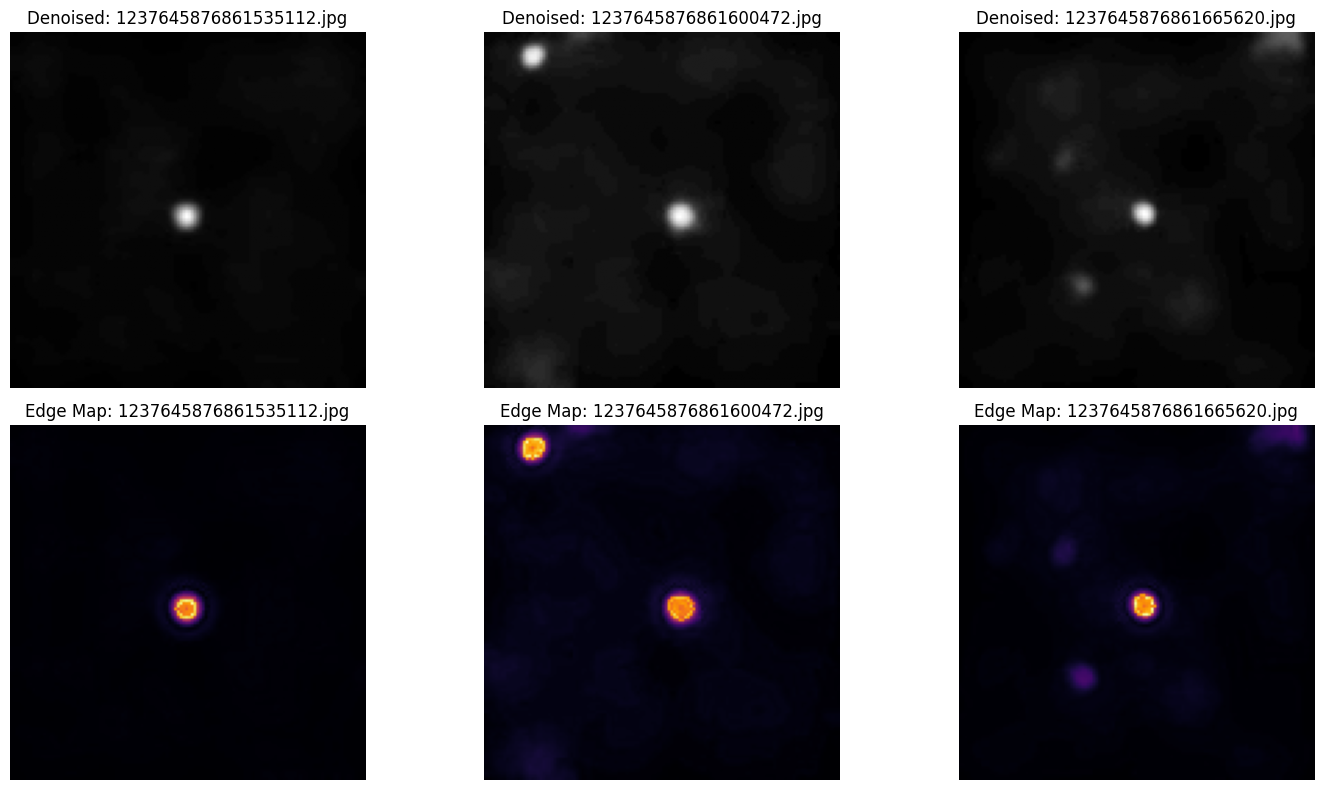


Class: GALAXY


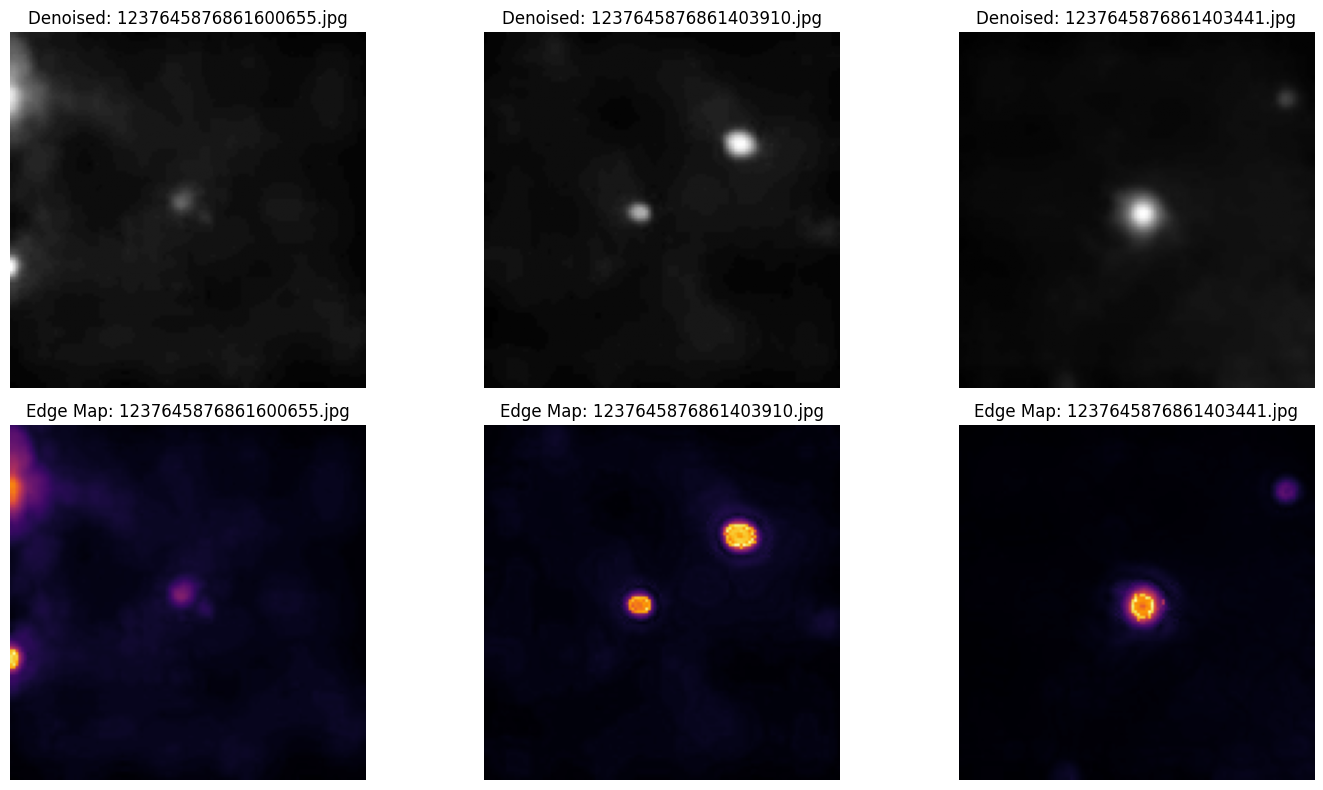

In [ ]:
def display_edge_comparison(features_df, denoised_dir, edge_maps_dir, num_samples=3):
    """Displays denoised vs combined edge maps side-by-side."""
    class_col = 'original_class'
    if class_col not in features_df.columns:
        print("Error: 'original_class' column not found.")
        return

    classes = features_df[class_col].unique()
    for obj_class in classes:
        if pd.isna(obj_class): continue
        print(f"\nClass: {obj_class}")
        class_df = features_df[features_df[class_col] == obj_class]
        valid_df = class_df[class_df['error_edge'].isnull()] if 'error_edge' in class_df.columns else class_df
        valid_df = valid_df[valid_df['error'].isnull()] if 'error' in valid_df.columns else valid_df
        if valid_df.empty:
            print(f"No valid samples for {obj_class}")
            continue

        samples = random.sample(list(valid_df['filename']), min(num_samples, len(valid_df)))

        fig, axes = plt.subplots(2, num_samples, figsize=(5*num_samples, 8))
        if num_samples == 1:
            axes = np.array(axes).reshape(2,1)

        for i, filename in enumerate(samples):
            denoised_path = os.path.join(denoised_dir, obj_class, filename)
            edge_path = os.path.join(edge_maps_dir, obj_class, filename)

            denoised = cv2.imread(denoised_path, cv2.IMREAD_GRAYSCALE)
            edge = cv2.imread(edge_path, cv2.IMREAD_GRAYSCALE)

            axes[0, i].imshow(denoised, cmap='gray')
            axes[0, i].set_title(f"Denoised: {filename}")
            axes[0, i].axis('off')

            axes[1, i].imshow(edge, cmap='inferno')
            axes[1, i].set_title(f"Edge Map: {filename}")
            axes[1, i].axis('off')

        plt.tight_layout()
        plt.show()

# Run visualization for a small random sample
display_edge_comparison(features_step2_df, DENOISED_DATA_DIR, EDGE_MAPS_DIR, num_samples=3)


## Chapter 2.6 Canny Edge Maps (For segmentation)

In [57]:
EDGE_MAPS_DIR = os.path.join(WORK_DIR, "edge_maps")
for cls in ["STAR", "GALAXY"]:
    os.makedirs(os.path.join(EDGE_MAPS_DIR, cls), exist_ok=True)

print(f"Canny edge maps will be written to: {EDGE_MAPS_DIR}")

for _, row in tqdm(metadata_df.iterrows(),
                   total=len(metadata_df),
                   desc="Generating Canny edge maps"):
    fname      = row["filename"]
    obj_class  = row["class"]
    src_path   = os.path.join(DENOISED_DATA_DIR, obj_class, fname)
    dst_path   = os.path.join(EDGE_MAPS_DIR,  obj_class, fname)

    img = cv2.imread(src_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue

    edge = astronomical_canny(img, row.to_dict())   # uint8 already
    cv2.imwrite(dst_path, edge)

Canny edge maps will be written to: astro_processing/edge_maps


Generating Canny edge maps:   0%|          | 0/3999 [00:00<?, ?it/s]

# Chapter 3: Segmentation and Feature Extraction

This chapter applies three different segmentation methods to the denoised astronomical images

In [62]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.measure import label, regionprops
from skimage.segmentation import chan_vese
from skimage import filters
from skimage.feature import shape_index
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

WORK_DIR = "./astro_processing"
DENOISED_DATA_DIR = os.path.join(WORK_DIR, "denoised_dataset")
EDGE_MAPS_DIR = os.path.join(WORK_DIR, "edge_maps")
FEATURES_DIR = os.path.join(WORK_DIR, "features")

FEATURES_STEP2_CSV = os.path.join(FEATURES_DIR, "features_step2.csv")
FEATURES_STEP3_CSV = os.path.join(FEATURES_DIR, "features_step3.csv")
os.makedirs(FEATURES_DIR, exist_ok=True)


## 3.1 Segmentation Preview Function

We define a visualization utility to display results from all three segmentation algorithms side-by-side.  


In [63]:
def display_all_segmentation_results(edge_mask, chanvese_mask, watershed_mask, filename):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(edge_mask, cmap='nipy_spectral') if edge_mask is not None else axs[0].text(0.5, 0.5, "No Result", ha='center')
    axs[0].set_title("Edge Segmentation")
    axs[0].axis('off')

    axs[1].imshow(chanvese_mask, cmap='nipy_spectral') if chanvese_mask is not None else axs[1].text(0.5, 0.5, "No Result", ha='center')
    axs[1].set_title("Chan-Vese Segmentation")
    axs[1].axis('off')

    axs[2].imshow(watershed_mask, cmap='nipy_spectral') if watershed_mask is not None else axs[2].text(0.5, 0.5, "No Result", ha='center')
    axs[2].set_title("Watershed Segmentation")
    axs[2].axis('off')

    fig.suptitle(f"Segmentation Results for {filename}")
    plt.show()


## 3.2 Segmentation Algorithms


We define the three segmentation approaches that will be applied to the denoised grayscale images:

- **Edge Segmentation**: Threshold and label connected components from the combined edge map.
- **Chan–Vese Active Contours**: A level-set method that evolves a region boundary based on intensity homogeneity.
- **Watershed Segmentation**: Mimics a topographic flooding process to identify basins and boundaries using gradients.

Each method offers complementary strengths — edge-based methods respond well to strong contours, while Chan–Vese can capture objects with fuzzy edges. Watershed excels at separating touching objects.

In [64]:
def segment_from_edges(edge_map, threshold_value=0.3, min_object_area=50):
    if edge_map is None:
        return None, 0, None
    edges_norm = cv2.normalize(edge_map.astype(np.float32), None, 0, 1, cv2.NORM_MINMAX)
    binary_mask = (edges_norm > threshold_value).astype(np.uint8)
    labeled_mask, num_labels = label(binary_mask, return_num=True, connectivity=2)
    if num_labels < 1:
        return labeled_mask, 0, None
    props = regionprops(labeled_mask)
    valid_regions = [prop for prop in props if prop.area >= min_object_area]
    if not valid_regions:
        return labeled_mask, 0, None
    largest_region = max(valid_regions, key=lambda region: region.area)
    largest_region_label = largest_region.label
    return labeled_mask, len(valid_regions), largest_region_label

def segment_chanvese(gray_image, mu=0.01, lambda1=0.5, lambda2=1, tol=1e-3, max_iter=200):
    if gray_image is None:
        return None
    normalized_image = gray_image.astype(np.float64) / 255.0
    segmentation = chan_vese(normalized_image, mu=mu, lambda1=lambda1, lambda2=lambda2,
                               tol=tol, max_num_iter=max_iter, dt=0.5)
    return segmentation.astype(np.uint8)

def segment_watershed(denoised_image, gaussian_sigma=1.0, dt_thresh_factor=0.9, open_iter=1):
    if denoised_image is None:
        return None, 0
    blurred = filters.gaussian(denoised_image, sigma=gaussian_sigma)
    blurred = (blurred * 255).astype(np.uint8)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=open_iter)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, dt_thresh_factor * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    _, markers = cv2.connectedComponents(sure_fg)
    markers += 1
    markers[unknown == 255] = 0
    image_rgb = cv2.cvtColor(denoised_image, cv2.COLOR_GRAY2BGR)
    markers = cv2.watershed(image_rgb, markers)
    labeled_mask = markers.astype(np.uint16)
    num_labels = np.max(labeled_mask)
    return labeled_mask, num_labels


## 3.3 Feature Extraction from Segmentations

Once an object is segmented, we extract geometric and intensity-based properties of the largest valid region.  
This includes:

- **Morphological descriptors** such as area, eccentricity, aspect ratio, and orientation.
- **Intensity features** like mean, max, min, and standard deviation inside the region.
- **Shape Index**: A curvature-based descriptor computed over the region using a Gaussian scale.

These descriptors enrich the feature space, helping the classifier distinguish between point-like stars and extended galaxies.



In [135]:
def extract_segmentation_features(labeled_mask, largest_region_label, intensity_image):
    if largest_region_label is None or intensity_image is None or labeled_mask is None:
        return None
    props = regionprops(labeled_mask, intensity_image=intensity_image)
    target_props = None
    for prop in props:
        if prop.label == largest_region_label:
            target_props = prop
            break
    if target_props is None:
        return None
    minor_axis = target_props.minor_axis_length
    major_axis = target_props.major_axis_length
    aspect_ratio = major_axis / minor_axis if minor_axis > 0 else 0
    features = {
        'segment_area': target_props.area,
        'segment_perimeter': target_props.perimeter,
        'segment_eccentricity': target_props.eccentricity,
        'segment_solidity': target_props.solidity,
        'segment_orientation': target_props.orientation,
        'segment_major_axis_length': major_axis,
        'segment_minor_axis_length': minor_axis,
        'segment_aspect_ratio': aspect_ratio,
        'segment_mean_intensity': target_props.mean_intensity,
        'segment_max_intensity': target_props.max_intensity,
        'segment_min_intensity': target_props.min_intensity,
        'segment_bbox_area': target_props.area_bbox,
        'segment_weighted_centroid_row': target_props.centroid_weighted[0],
        'segment_weighted_centroid_col': target_props.centroid_weighted[1],
    }
    region_pixels = intensity_image[labeled_mask == largest_region_label]
    features['segment_std_intensity'] = np.std(region_pixels) if region_pixels.size > 0 else 0
    return features

def extract_shape_index_feature(intensity_image, labeled_mask, target_label, sigma=3):
    if intensity_image is None or labeled_mask is None or target_label is None:
        return None
    try:
        si_map = shape_index(intensity_image.astype(np.float32) / 255.0, sigma=sigma)
        region_mask = (labeled_mask == target_label)
        if np.any(region_mask):
            return np.mean(si_map[region_mask])
        else:
            return None
    except Exception as e:
        print(f"Error calculating shape index: {e}")
        return None


## 3.4 Apply Segmentations and Aggregate Features

In [91]:
print(f"Loading features from: {FEATURES_STEP2_CSV}")
try:
    features_df = pd.read_csv(FEATURES_STEP2_CSV)
    print(f"Loaded {len(features_df)} entries.")
except FileNotFoundError:
    print(f"Error: Features file not found: {FEATURES_STEP2_CSV}")
    raise SystemExit("Stopping: Cannot proceed without features from Chapter 2.")

def infer_original_class(filename):
    lower_fname = filename.lower()
    if "galaxy" in lower_fname:
        return "GALAXY"
    elif "star" in lower_fname:
        return "STAR"
    else:
        return None

segmentation_features_list = []

def extract_for_image_segmentation(row, denoised_dir,edge_dir, visualize_segmentation, visualize_limit, visualization_count):
    filename = row['filename']
    original_class = row['original_class'] if 'original_class' in features_df.columns else infer_original_class(filename)

    if original_class is None:
        segmentation_features_list.append({'filename': filename, 'error': 'NoClassInfo'})

    denoised_img_path = os.path.join(denoised_dir, original_class, filename)

    current_features = {'filename': filename, 'original_class': original_class}

    if not os.path.exists(denoised_img_path):
        current_features['denoised_error'] = f'DenoisedImageNotFound: {denoised_img_path}'
        segmentation_features_list.append(current_features)

    if not os.path.exists(edge_dir):
        current_features['edge_error'] = f'EdgeNotFound: {edge_dir}'

    denoised_img = cv2.imread(denoised_img_path, cv2.IMREAD_GRAYSCALE)
    edge_img = cv2.imread(edge_dir, cv2.IMREAD_GRAYSCALE) if os.path.exists(edge_dir) else None

    if denoised_img is None:
        current_features['denoised_error'] = 'FailedToLoadDenoised'
        segmentation_features_list.append(current_features)
    edge_mask = None
    try:
        if edge_img is not None:
            edge_mask, num_valid_labels_edge, largest_region_label_edge = segment_from_edges(
                edge_img,
                threshold_value=0.3,
                min_object_area=100
            )
            current_features['edge_segmentation_num_objects'] = num_valid_labels_edge
            if largest_region_label_edge is not None and edge_mask is not None:
                features_edge = extract_segmentation_features(edge_mask, largest_region_label_edge, denoised_img)
                if features_edge:
                    for key, value in features_edge.items():
                        current_features[f"edge_{key}"] = value
                    shape_index_edge = extract_shape_index_feature(denoised_img, edge_mask, largest_region_label_edge)
                    if shape_index_edge is not None:
                        current_features["edge_segment_shape_index_mean"] = shape_index_edge
                else:
                    current_features['edge_seg_error'] = 'FeatureExtractionFailed'
            else:
                current_features['edge_seg_error'] = 'NoValidObjectFound'
        else:
            current_features['edge_seg_error'] = 'EdgeImageNotFound'
    except Exception as e:
        current_features['edge_seg_error'] = str(e)

    # --- Chan–Vese Segmentation ---
    chanvese_mask = None
    try:
        binary_mask = segment_chanvese(denoised_img)
        if binary_mask is not None:
            labeled_mask_chan, num_labels_chan = label(binary_mask, return_num=True, connectivity=2)
            props_chan = regionprops(labeled_mask_chan)
            valid_regions_chan = [prop for prop in props_chan if prop.area >= 100]
            current_features['chanvese_segmentation_num_objects'] = len(valid_regions_chan)
            if valid_regions_chan:
                largest_region_chan = max(valid_regions_chan, key=lambda region: region.area)
                largest_region_label_chan = largest_region_chan.label
                chanvese_mask = labeled_mask_chan
                features_chan = extract_segmentation_features(labeled_mask_chan, largest_region_label_chan, denoised_img)
                if features_chan:
                    for key, value in features_chan.items():
                        current_features[f"chanvese_{key}"] = value
                    shape_index_chan = extract_shape_index_feature(denoised_img, labeled_mask_chan, largest_region_label_chan)
                    if shape_index_chan is not None:
                        current_features["chanvese_segment_shape_index_mean"] = shape_index_chan
                else:
                    current_features['chanvese_seg_error'] = 'FeatureExtractionFailed'
            else:
                current_features['chanvese_seg_error'] = 'NoValidObjectFound'
        else:
            current_features['chanvese_seg_error'] = 'ChanVeseSegmentationFailed'
    except Exception as e:
        current_features['chanvese_seg_error'] = str(e)

    # --- Watershed Segmentation ---
    watershed_mask = None
    try:
        labeled_mask_ws, num_labels_ws = segment_watershed(denoised_img)
        if labeled_mask_ws is not None and num_labels_ws > 0:
            props_ws = regionprops(labeled_mask_ws)
            valid_regions_ws = [prop for prop in props_ws if prop.area >= 100]
            current_features['watershed_segmentation_num_objects'] = len(valid_regions_ws)
            if valid_regions_ws:
                largest_region_ws = max(valid_regions_ws, key=lambda region: region.area)
                largest_region_label_ws = largest_region_ws.label
                watershed_mask = labeled_mask_ws
                features_ws = extract_segmentation_features(labeled_mask_ws, largest_region_label_ws, denoised_img)
                if features_ws:
                    for key, value in features_ws.items():
                        current_features[f"watershed_{key}"] = value
                    shape_index_ws = extract_shape_index_feature(denoised_img, labeled_mask_ws, largest_region_label_ws)
                    if shape_index_ws is not None:
                        current_features["watershed_segment_shape_index_mean"] = shape_index_ws
                else:
                    current_features['watershed_seg_error'] = 'FeatureExtractionFailed'
            else:
                current_features['watershed_seg_error'] = 'NoValidObjectFound'
        else:
            current_features['watershed_seg_error'] = 'WatershedSegmentationFailed'
    except Exception as e:
        current_features['watershed_seg_error'] = str(e)

    segmentation_features_list.append(current_features)

    if visualize_segmentation and visualization_count < visualize_limit:
        display_all_segmentation_results(edge_mask, chanvese_mask, watershed_mask, filename)
        visualization_count += 1

    return segmentation_features_list

Loading features from: ./astro_processing/features/features_step2.csv
Loaded 3999 entries.


In [67]:

for index, row in tqdm(features_df.iterrows(), total=features_df.shape[0], desc="Segmenting"):
    extract_for_image_segmentation(row, DENOISED_DATA_DIR,EDGE_MAPS_DIR, False, 3, 0)

Segmenting:   0%|          | 0/3999 [00:00<?, ?it/s]

## 3.5 Combine and Save Final Feature Table

In [73]:
# --- Combine Features and Save ---
print("\nCombining features...")
segmentation_df = pd.DataFrame(segmentation_features_list)
final_features_df = pd.merge(features_df, segmentation_df, on='filename', how='left')

# Fill any missing numeric values with zeros
numeric_cols = final_features_df.select_dtypes(include=np.number).columns
final_features_df[numeric_cols] = final_features_df[numeric_cols].fillna(0)

print(f"Final combined feature set shape: {final_features_df.shape}")
print("Columns added:")
for col in final_features_df.columns:
    if col not in features_df.columns:
        print(f"  {col}")

# Save to CSV
final_features_df.to_csv(FEATURES_STEP3_CSV, index=False)
print(f"Chapter 3 features saved to: {FEATURES_STEP3_CSV}")
print("\nChapter 3 complete.")



Combining features...
Final combined feature set shape: (3999, 59)
Columns added:
  original_class_x
  original_class_y
  edge_seg_error
  chanvese_segmentation_num_objects
  chanvese_segment_area
  chanvese_segment_perimeter
  chanvese_segment_eccentricity
  chanvese_segment_solidity
  chanvese_segment_orientation
  chanvese_segment_major_axis_length
  chanvese_segment_minor_axis_length
  chanvese_segment_aspect_ratio
  chanvese_segment_mean_intensity
  chanvese_segment_max_intensity
  chanvese_segment_min_intensity
  chanvese_segment_bbox_area
  chanvese_segment_weighted_centroid_row
  chanvese_segment_weighted_centroid_col
  chanvese_segment_std_intensity
  chanvese_segment_shape_index_mean
  watershed_segmentation_num_objects
  watershed_segment_area
  watershed_segment_perimeter
  watershed_segment_eccentricity
  watershed_segment_solidity
  watershed_segment_orientation
  watershed_segment_major_axis_length
  watershed_segment_minor_axis_length
  watershed_segment_aspect_ratio
 

# Chapter 4: Classification with Gradient Boosting


In this final stage, we use the features extracted from previous chapters to train a supervised classifier.  
Gradient Boosting was chosen due to its strong performance in preliminary experiments and ro

In [74]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib



## 4.1 Load Processed Features

We load the feature set prepared in Chapter 3. This dataset includes power spectrum analysis, edge-based, segmentation-based, and color-based features.

In [75]:
WORK_DIR = "./astro_processing"
FEATURES_DIR = os.path.join(WORK_DIR, "features")
FEATURES_STEP3_CSV = os.path.join(FEATURES_DIR, "features_step3.csv")

try:
    features_df = pd.read_csv(FEATURES_STEP3_CSV)
    print(f"Loaded {len(features_df)} feature entries.")
except Exception as e:
    raise SystemExit(f"Failed to load features CSV: {e}")


Loaded 3999 feature entries.


## 4.2 Prepare Data for Training

We isolate numeric features for model training, handle missing values, and encode class labels into numerical format (`STAR`, `GALAXY`).

In [76]:
target_column = 'original_class_x'
exclude_cols = ['filename', 'original_class', 'error', 'error_edge', 'segment_error', 'psa_prelim_class_guess']
numeric_cols = features_df.select_dtypes(include=np.number).columns.tolist()
feature_columns = [col for col in numeric_cols if col not in exclude_cols and col != target_column]

if target_column not in features_df.columns:
    if 'class' in features_df.columns:
        target_column = 'class'
    else:
        raise SystemExit("Target column not found.")

X = features_df[feature_columns]
y_raw = features_df[target_column]

X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.mean())

le = LabelEncoder()
y = le.fit_transform(y_raw)
class_names = list(le.classes_)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")


Training samples: 3599, Test samples: 400


## 4.3 Gradient Boosting Classifier Training

We train a `GradientBoostingClassifier`, which iteratively improves prediction accuracy by constructing an ensemble of decision trees. Each subsequent tree corrects the residual errors of the previous one.

Accuracy: 0.7725

Classification Report:
              precision    recall  f1-score   support

      GALAXY       0.75      0.82      0.78       200
        STAR       0.80      0.72      0.76       200

    accuracy                           0.77       400
   macro avg       0.78      0.77      0.77       400
weighted avg       0.78      0.77      0.77       400



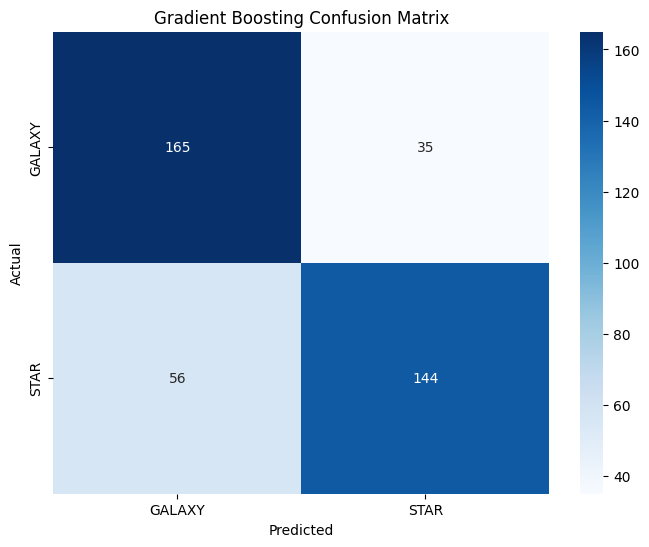

['./astro_processing/model/gradient_boosting_model.pkl']

In [77]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)
model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(class_names)))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Gradient Boosting Confusion Matrix')
plt.show()

joblib.dump({
    'model': model,
    'scaler': scaler
}, './astro_processing/model/gradient_boosting_model.pkl')


# Chapter 5: Processing a New Image

In this chapter, we'll download a new astronomical image from the Sloan Digital Sky Survey (SDSS) that wasn't part of our original dataset. We'll then process this image through the entire pipeline, including denoising, feature extraction, segmentation, and classification using our trained model.​

## Step 1: Download a New Image from SDSS

In [130]:
import os
import requests
import urllib.request
import pandas as pd
import random
from tqdm import tqdm

# Configuration
DATASET_PATH = "./astro_processing/raw_dataset"
METADATA_CSV = os.path.join(DATASET_PATH, "metadata.csv")
SDSS_API_URL = "http://skyserver.sdss.org/dr18/SkyServerWS/SearchTools/SqlSearch"

# SQL query to fetch galaxy data
QUERY = """
SELECT TOP 1
  p.objID, p.ra, p.dec, p.u, p.g, p.r, p.i, p.z, p.type,
  f.psfWidth_r AS psf_fwhm_r,
  'http://skyserver.sdss.org/dr18/SkyServerWS/ImgCutout/getjpeg?ra='
    + CONVERT(nvarchar, p.ra) + '&dec=' + CONVERT(nvarchar, p.dec)
    + '&scale=0.2&width=128&height=128' AS img_url
FROM PhotoObj AS p
JOIN Field AS f ON p.fieldID = f.fieldID
WHERE p.type = 3
"""

# Fetch data from SDSS
def fetch_sdss_data():
    response = requests.get(SDSS_API_URL, params={"cmd": QUERY, "format": "json"})
    try:
        return response.json()[0]["Rows"]
    except Exception:
        return []

# Download images
def download_images(rows, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    metadata = []
    for row in tqdm(rows, desc="Downloading Images"):
        fname = f"{row['objID']}.jpg"
        path = os.path.join(out_dir, fname)
        try:
            urllib.request.urlretrieve(row["img_url"], path)
            metadata.append([
                fname, "GALAXY",
                row["ra"], row["dec"],
                row["u"], row["g"], row["r"], row["i"], row["z"],
                row.get("psf_fwhm_r")
            ])
        except Exception as e:
            print(f"Failed to download {fname}: {e}")
    return metadata

# Main execution
rows = fetch_sdss_data()
if rows:
    metadata = download_images(rows, os.path.join(DATASET_PATH, "GALAXY"))
    cols = ["filename", "class", "ra", "dec", "u", "g", "r", "i", "z", "psf_fwhm_r"]
    pd.DataFrame(metadata, columns=cols).to_csv(METADATA_CSV, index=False)
else:
    print("No data fetched from SDSS.")


## Step 2: Preprocess the New Image

In [131]:
import cv2
import numpy as np
from skimage.restoration import denoise_nl_means, estimate_sigma

# Load the image
image_path = os.path.join(DATASET_PATH, "GALAXY", metadata[0][0])
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Estimate the noise standard deviation from the noisy image
sigma_est = np.mean(estimate_sigma(image))

# Apply Non-Local Means denoising
denoised = denoise_nl_means(image, h=1.15 * sigma_est, fast_mode=True,
                            patch_size=5, patch_distance=3)

# Convert back to uint8
denoised_uint8 = (denoised * 255).astype(np.uint8)

# Save the denoised image
denoised_path = os.path.join(DATASET_PATH, "GALAXY", f"denoised_{metadata[0][0]}")
cv2.imwrite(denoised_path, denoised_uint8)


True

## Step 3: Feature Extraction

In [132]:
def extract_for_image_segmentation_any(row, denoised_dir, edge_dir,
                                       visualize_segmentation=False,
                                       visualize_limit=1,
                                       visualization_count=0):
    """
    New universal segmentation extractor.
    Does NOT require class folder logic. Assumes:
        - Denoised images live in denoised_dir/<class>/filename
        - Edge images live in edge_dir/filename
    Returns a single segmentation feature dictionary.
    """
    from skimage.measure import label, regionprops

    filename = row['filename']
    obj_class = row.get('original_class') or row.get('class') or 'UNKNOWN'

    seg_feats = {'filename': filename, 'original_class': obj_class}

    # File paths
    denoised_path = os.path.join(denoised_dir, obj_class, filename)
    edge_path     = os.path.join(edge_dir, filename)

    # Load denoised image
    if not os.path.exists(denoised_path):
        seg_feats['denoised_error'] = f"Missing: {denoised_path}"
        return seg_feats
    denoised = cv2.imread(denoised_path, cv2.IMREAD_GRAYSCALE)
    if denoised is None:
        seg_feats['denoised_error'] = "FailedToLoadDenoised"
        return seg_feats

    # Load edge image
    if not os.path.exists(edge_path):
        seg_feats['edge_error'] = f"Missing: {edge_path}"
        edge_img = None
    else:
        edge_img = cv2.imread(edge_path, cv2.IMREAD_GRAYSCALE)

    # EDGE SEGMENTATION
    try:
        if edge_img is not None:
            mask, n_labels, top_label = segment_from_edges(edge_img, threshold_value=0.3, min_object_area=100)
            seg_feats["edge_segmentation_num_objects"] = n_labels
            if mask is not None and top_label is not None:
                feats = extract_segmentation_features(mask, top_label, denoised)
                seg_feats.update({f"edge_{k}": v for k, v in feats.items()})
                si = extract_shape_index_feature(denoised, mask, top_label)
                if si is not None:
                    seg_feats["edge_segment_shape_index_mean"] = si
            else:
                seg_feats["edge_seg_error"] = "NoValidObjectFound"
        else:
            seg_feats["edge_seg_error"] = "EdgeImageNotFound"
    except Exception as e:
        seg_feats["edge_seg_error"] = str(e)

    # CHAN–VESE SEGMENTATION
    try:
        mask = segment_chanvese(denoised)
        if mask is not None:
            lbls, n = label(mask, return_num=True)
            props = [p for p in regionprops(lbls) if p.area >= 100]
            seg_feats["chanvese_segmentation_num_objects"] = len(props)
            if props:
                top = max(props, key=lambda p: p.area).label
                feats = extract_segmentation_features(lbls, top, denoised)
                seg_feats.update({f"chanvese_{k}": v for k, v in feats.items()})
                si = extract_shape_index_feature(denoised, lbls, top)
                if si is not None:
                    seg_feats["chanvese_segment_shape_index_mean"] = si
            else:
                seg_feats["chanvese_seg_error"] = "NoValidObjectFound"
        else:
            seg_feats["chanvese_seg_error"] = "ChanVeseFailed"
    except Exception as e:
        seg_feats["chanvese_seg_error"] = str(e)

    # WATERSHED SEGMENTATION
    try:
        lbls, n = segment_watershed(denoised)
        if lbls is not None and n > 0:
            props = [p for p in regionprops(lbls) if p.area >= 100]
            seg_feats["watershed_segmentation_num_objects"] = len(props)
            if props:
                top = max(props, key=lambda p: p.area).label
                feats = extract_segmentation_features(lbls, top, denoised)
                seg_feats.update({f"watershed_{k}": v for k, v in feats.items()})
                si = extract_shape_index_feature(denoised, lbls, top)
                if si is not None:
                    seg_feats["watershed_segment_shape_index_mean"] = si
            else:
                seg_feats["watershed_seg_error"] = "NoValidObjectFound"
        else:
            seg_feats["watershed_seg_error"] = "WatershedFailed"
    except Exception as e:
        seg_feats["watershed_seg_error"] = str(e)
    return seg_feats

In [137]:
# Load metadata
metadata_df = pd.read_csv("./astro_processing/raw_dataset/metadata.csv")
print(f"Loaded metadata: {len(metadata_df)} entries")

# Initialize processors
psa_extractor = PSA()
nlmeans = NLMeans()

# Directories
DENOISED_DIR = './astro_processing/raw_dataset/denoised'
EDGE_MAP_DIR = './astro_processing/raw_dataset/edge_map'
FEATURES_DIR = './astro_processing/raw_dataset/features'
os.makedirs(EDGE_MAP_DIR, exist_ok=True)
os.makedirs(FEATURES_DIR, exist_ok=True)

all_features = []
all_segmentation_features = []

for _, row in tqdm(metadata_df.iterrows(), total=len(metadata_df), desc="Processing images"):
    filename = row['filename']
    obj_class = row['class']

    input_path = os.path.join('./astro_processing/raw_dataset', obj_class, filename)
    denoised_path = os.path.join(DENOISED_DIR, obj_class, filename)
    edge_path = os.path.join(EDGE_MAP_DIR, filename)
    os.makedirs(os.path.dirname(denoised_path), exist_ok=True)

    img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue

    # Denoise
    denoised_img = nlmeans.solve(img)
    cv2.imwrite(denoised_path, denoised_img)

    # PSA features
    features = psa_extractor.extract_psa_features(denoised_img)
    features['filename'] = filename
    features['original_class'] = obj_class

    # Edge features
    meta = row.to_dict()
    ridge_map = multi_scale_ridge_detection(denoised_img, meta)
    wavelet_map = adaptive_wavelet_edges(denoised_img, meta)
    grad_map = gradient_of_laplacian(denoised_img)

    ridge_feats = edge_metrics(ridge_map)
    wavelet_feats = edge_metrics(wavelet_map)
    grad_feats = edge_metrics(grad_map)
    canny_map = astronomical_canny(denoised_img, meta)

    # Save Canny map
    cv2.imwrite(edge_path, (canny_map * 255).astype(np.uint8))

    # Combine features
    features.update({f"ridge_{k}": v for k, v in ridge_feats.items()})
    features.update({f"wavelet_{k}": v for k, v in wavelet_feats.items()})
    features.update({f"grad_{k}": v for k, v in grad_feats.items()})
    add_colors_feature(features, metadata_df)
    all_features.append(features)

    # Segmentation features using the Canny edge
    row_dict = row.to_dict()
    row_dict['original_class'] = obj_class
    seg_feats = extract_for_image_segmentation_any(row_dict, DENOISED_DIR, EDGE_MAP_DIR, False, 3, 0)


# Merge & save
for f in all_features:
    for c in ["color_u_g", "color_g_r", "color_r_i", "color_i_z"]:
        if isinstance(f.get(c), pd.Series):
            f[c] = f[c].iloc[0]
features_df = pd.DataFrame(all_features)
segmentation_df = pd.DataFrame([seg_feats])
final_features_df = pd.merge(features_df, segmentation_df, on='filename', how='left')

final_features_df.to_csv(os.path.join(FEATURES_DIR, 'features.csv'), index=False)


Loaded metadata: 1 entries


Processing images: 100%|██████████| 1/1 [00:06<00:00,  6.16s/it]


## Step 4: Classification

<ipython-input-141-addefb4c6c97>:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  feature_input = feature_input.applymap(lambda x: x.iloc[0] if isinstance(x, pd.Series) else x)


Predicted Class: GALAXY


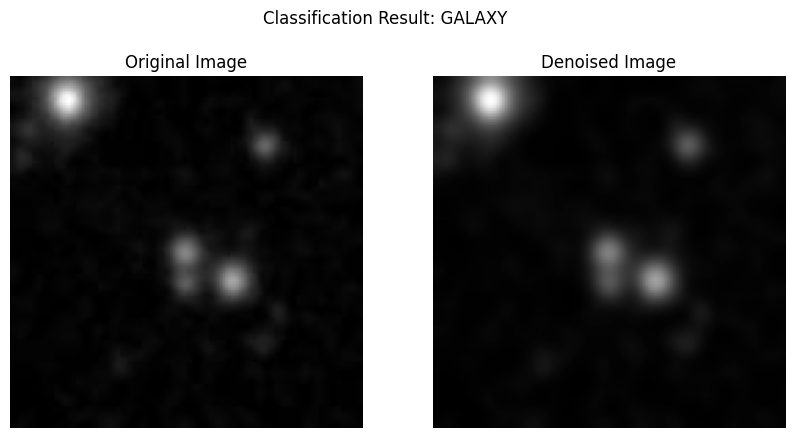

In [141]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load model and scaler
data = joblib.load('./astro_processing/model/gradient_boosting_model.pkl')
model = data['model']
scaler = data['scaler']

# Get expected feature names from scaler (used during training)
expected_features = scaler.feature_names_in_

# Filter final features to match training columns
feature_input = final_features_df.copy()
feature_input = feature_input[[col for col in expected_features if col in feature_input.columns]]

# Ensure all values are scalar (if anything is a pd.Series, extract the scalar)
feature_input = feature_input.applymap(lambda x: x.iloc[0] if isinstance(x, pd.Series) else x)

# Reorder to match training feature order
feature_input = feature_input.reindex(columns=expected_features)

# Scale
feature_vector_scaled = scaler.transform(feature_input)

# Predict numeric label
predicted_class_numeric = model.predict(feature_vector_scaled)[0]

# Map to class name
class_map = {0: "GALAXY", 1: "STAR"}  # or reverse depending on your training
predicted_class = class_map.get(predicted_class_numeric, "UNKNOWN")

print(f"Predicted Class: {predicted_class}")

# Visualize (make sure image and denoised_uint8 are defined)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(denoised_uint8, cmap='gray')
plt.title("Denoised Image")
plt.axis('off')

plt.suptitle(f"Classification Result: {predicted_class}")
plt.show()


# Chapter 6 Edge-Detector Evaluation

In [ ]:
FEATURES_CSV       = "astro_processing/features/features_step3.csv"
METADATA_CSV       = "dataset/metadata.csv"
DENOISED_DATA_DIR  = "astro_processing/denoised_dataset"

features_df = pd.read_csv(FEATURES_CSV)
meta_df     = pd.read_csv(METADATA_CSV)
df = features_df.merge(meta_df, on="filename", how="left")   # keeps all original rows

def edge_metrics(edge_map):
    n = cv2.normalize(edge_map.astype(np.float32), None, 0, 1, cv2.NORM_MINMAX)
    vals = n[n > 0.01]
    return {
        "density":       float(np.mean(n > 0.1)),
        "connectivity":  float(calculate_connectivity(n)),
        "entropy":       float(calculate_entropy(n)),
        "noise_ratio":   float(np.mean(n < 0.05)),
        "mean_strength": float(np.mean(vals) if vals.size else 0.0),
    }

edge_fns = {
    "CANNY"   : astronomical_canny,
    "RIDGE"   : multi_scale_ridge_detection,
    "WAVELET" : adaptive_wavelet_edges,
    "GRAD"    : gradient_of_laplacian,   # LoG gradient
}

for name, fn in edge_fns.items():
    rows = []
    for _, row in df.iterrows():
        img_path = os.path.join(DENOISED_DATA_DIR, row["original_class_x"], row["filename"])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            rows.append({k:0.0 for k in ["density","connectivity","entropy","noise_ratio","mean_strength"]})
            continue
        edge_map = fn(img, row.to_dict()) if name != "GRAD" else fn(img)
        rows.append(edge_metrics(edge_map))
    df = pd.concat([df, pd.DataFrame(rows).add_prefix(f"{name}_")], axis=1)

edge_prefixes = [f"{k}_" for k in edge_fns] + ["comb_edge_"]
numeric_cols  = df.select_dtypes(include=np.number).columns
base_cols     = [c for c in numeric_cols if not any(c.startswith(p) for p in edge_prefixes)]

le = LabelEncoder().fit(df["original_class_x"])
y  = le.transform(df["original_class_x"])

def evaluate(extra_cols, tag):
    X = df[base_cols + extra_cols].fillna(0)
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
    scaler = StandardScaler().fit(Xtr)
    clf    = SVC(kernel="linear", C=1.0, random_state=42)
    clf.fit(scaler.transform(Xtr), ytr)
    pred = clf.predict(scaler.transform(Xte))
    acc  = accuracy_score(yte, pred)
    print(f"\n==== {tag}  ({len(extra_cols)} edge feats)  ACC={acc:.4f} ====")
    print(classification_report(yte, pred, target_names=le.classes_, zero_division=0, digits=3))

from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s)+1))

for combo in powerset(edge_fns.keys()):
    cols = []
    for k in combo:
        cols.extend([f"{k}_{m}" for m in ["density","connectivity","entropy","noise_ratio","mean_strength"]])
    tag = "+".join(combo)
    evaluate(cols, tag)

comb_cols = [c for c in numeric_cols if c.startswith("comb_edge_")]
evaluate(comb_cols, "COMBINED_MAP")


 Final Edge‐Detector Comparison

- **Single methods**  
  - Canny: 82.8%  
  - Ridge (Frangi): 84.5%  
  - Wavelet: 84.3%  
  - Gradient-of-LoG: 84.8%  

- **Best pair**  
  - Wavelet + Gradient: 87.0%  

- **Best trio**  
  - Ridge + Wavelet + Gradient: **87.8%**  

- **All four together**  
  - Canny + Ridge + Wavelet + Gradient: 87.8%  

---

**Why Ridge + Wavelet + Gradient wins**  
Each detector captures a different edge signature—Frangi for elongated filaments, wavelets for multi-scale contours, and the Laplacian gradient for fine, low-contrast features. Keeping them separate yields 15 rich features, allowing the SVM to carve a more precise decision boundary than the 5 global statistics of a single “combined” map.  


# Chapter 7: Classification Evaluation

In this chapter we compare several machine-learning models—SVM (with/without PCA) We load the feature matrix generated in *features_step3.csv* and compare several models:

* RBF SVM (baseline)  
* SVM + PCA (12 components)  
* A “model-zoo” of classical classifiers (RF, GB, k-NN, …)

Metrics are reported on an 80 / 20 stratified split.

## 7.1 Data cleaning  



* Remove identifier columns  
* Drop constant features  
* Separate **X** / **y**  
* Encode labels if they are strings  
* Standard-scale numeric features

In [145]:
# =========================
# 4 · Data loading & clean-up
# =========================
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

# Load the CSV ----------------------------------------------------
df = pd.read_csv("astro_processing/features/features_step3.csv")  # Adjust path if needed
label_column = "original_class_x"
if label_column not in df.columns:
    raise ValueError(f"Expected label column '{label_column}' was not found in CSV.")

# Drop ID-like columns -------------------------------------------
id_like_cols = [col for col in df.columns
                if "filename" in col.lower() or "id" in col.lower() or "unnamed" in col.lower()]
df.drop(columns=id_like_cols, inplace=True, errors='ignore')

# Drop zero-variance columns -------------------------------------
zero_var_cols = [col for col in df.columns if df[col].nunique() <= 1]
df.drop(columns=zero_var_cols, inplace=True, errors='ignore')

# Build feature matrix -------------------------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if label_column not in numeric_cols and label_column in numeric_cols:
    numeric_cols.remove(label_column)
elif label_column in numeric_cols:
    numeric_cols.remove(label_column)

X = df[numeric_cols].values

# Encode labels if necessary -------------------------------------
if df[label_column].dtype == object:
    le = LabelEncoder()
    df[label_column] = le.fit_transform(df[label_column])
y = df[label_column].values

# Scale features -------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Train / test split --------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
print(f"\nTrain set shape: {X_train.shape}, Test set shape: {X_test.shape}")



Train set shape: (3199, 44), Test set shape: (800, 44)


## 7.2 Baseline – RBF SVM


In [146]:
# =========================
# 4.1 SVM (no PCA)
# =========================
svm_no_pca = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_no_pca.fit(X_train, y_train)

y_pred_no_pca = svm_no_pca.predict(X_test)

cm_no_pca = confusion_matrix(y_test, y_pred_no_pca)
cr_no_pca = classification_report(y_test, y_pred_no_pca)

print("=== SVM WITHOUT PCA ===")
print("Confusion Matrix:\n", cm_no_pca)
print("Classification Report:\n", cr_no_pca)


=== SVM WITHOUT PCA ===
Confusion Matrix:
 [[315  85]
 [120 280]]
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.79      0.75       400
           1       0.77      0.70      0.73       400

    accuracy                           0.74       800
   macro avg       0.75      0.74      0.74       800
weighted avg       0.75      0.74      0.74       800



## 7.3 SVM + PCA (12 components)


In [147]:
# =========================
# 4.2 SVM + PCA
# =========================
n_components = 12
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca  = pca.transform(X_test)

svm_pca = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_pca.fit(X_train_pca, y_train)

y_pred_pca = svm_pca.predict(X_test_pca)

cm_pca = confusion_matrix(y_test, y_pred_pca)
cr_pca = classification_report(y_test, y_pred_pca)

print(f"\n=== SVM WITH PCA (n_components={n_components}) ===")
print("Confusion Matrix:\n", cm_pca)
print("Classification Report:\n", cr_pca)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative explained variance:", np.cumsum(pca.explained_variance_ratio_))



=== SVM WITH PCA (n_components=12) ===
Confusion Matrix:
 [[309  91]
 [139 261]]
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.77      0.73       400
           1       0.74      0.65      0.69       400

    accuracy                           0.71       800
   macro avg       0.72      0.71      0.71       800
weighted avg       0.72      0.71      0.71       800

Explained variance ratio: [0.22525823 0.19605547 0.1026336  0.06431566 0.05747617 0.03621152
 0.02864413 0.0267525  0.0244346  0.0237277  0.02221609 0.0212677 ]
Cumulative explained variance: [0.22525823 0.4213137  0.5239473  0.58826296 0.64573913 0.68195065
 0.71059479 0.73734729 0.76178189 0.78550959 0.80772568 0.82899337]


## 7.4 Model zoo (baseline classifiers)


In [148]:
# =========================
# 4.3 Model Zoo
# =========================
# If you need XGBoost:  !pip install xgboost
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report

classifiers = {
    "SVM": SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "KNeighbors": KNeighborsClassifier(n_neighbors=5),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "NaiveBayes": GaussianNB(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

for clf_name, clf in classifiers.items():
    print(f"\n=== {clf_name} ===")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", cr)



=== SVM ===
Confusion Matrix:
 [[315  85]
 [120 280]]
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.79      0.75       400
           1       0.77      0.70      0.73       400

    accuracy                           0.74       800
   macro avg       0.75      0.74      0.74       800
weighted avg       0.75      0.74      0.74       800


=== RandomForest ===
Confusion Matrix:
 [[325  75]
 [112 288]]
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.81      0.78       400
           1       0.79      0.72      0.75       400

    accuracy                           0.77       800
   macro avg       0.77      0.77      0.77       800
weighted avg       0.77      0.77      0.77       800


=== GradientBoosting ===
Confusion Matrix:
 [[324  76]
 [112 288]]
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.8

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:49:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix:
 [[320  80]
 [123 277]]
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.80      0.76       400
           1       0.78      0.69      0.73       400

    accuracy                           0.75       800
   macro avg       0.75      0.75      0.75       800
weighted avg       0.75      0.75      0.75       800



## 7.5 Classifier Benchmark Results

* Gradient Boosting achieves the highest test accuracy, with balanced precision-recall across classes—making it the preferred choice for the final pipeline.  
* XGBoost and Random Forest follow closely, confirming that ensemble tree methods model the feature interactions best.  
* Linear (LogReg) and distance-based (k-NN) methods plateau at ~80 %—adequate baselines but unable to capture non-linear decision boundaries present in the feature space.  
* Naïve Bayes underperforms, highlighting strong feature correlations that violate its independence assumption.  
* We therefore select **Gradient Boosting** as the production classifier and will fine-tune its hyper-parameters in the next iteration.